# Paper Title: "Premonition: Using Generative Models to Preempt Future Data Changes in Continual Learning"

## Demonstration of Premonition Synthetic Dataset Generation:


### About This Python Jupyter Notebook:
- This notebook demonstrates the step in Premonition where created prompts are passed to Stable Diffusion (SD) for synthetic image generation.
- The input to Premonition is a Realm name. In this notebook we load the SD prompts created for a realm.
- The three realms used in the paper for experiments are Birds, Food and Plants, so we demo each of these realms here.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import torch

from diffusers import StableDiffusionPipeline
from glob import glob
from PIL import Image

print('torch version = ',torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
output_path="Data/"  

torch version =  2.0.1


## Constants:

In [2]:
num_per_call=20 #adjust for your GPU RAM size
im_size=256 #mini Stable Diffusion default
num_inference_steps=40
guidance_scale=2.0
max_SD_prompt_len=300
model_id = "lambdalabs/miniSD-diffusers"


## Get mini Stable Diffusion model ready:

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(model_id,requires_safety_checker=False,safety_checker=None,torch_dtype=torch.float16)
pipe.set_progress_bar_config(disable=True)
pipe = pipe.to("cuda")

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Load prompts for Stable Diffusion and start making images:

In [4]:
def make_images_for_realm(realm,is_bio,num_images_per_prompt,is_demo=False):
    SD_prompts=pd.read_csv([x for x in glob("*.csv") if realm in x][0])["SD_prompt"].values
    if is_bio:
        classes=pd.read_csv([x for x in glob("*.csv") if realm in x][0])["species_latin_name"].values
    else:
        classes=pd.read_csv([x for x in glob("*.csv") if realm in x][0])["item_name"].values
    classes=[x.replace(' ','_') for x in classes]

    total_images=len(SD_prompts)*num_images_per_prompt
    calls_per_class=int(total_images/(len(SD_prompts)*num_per_call))
    print("About to make "+str(total_images)+" images for Realm == "+realm+". Will use "+str(calls_per_class)+" calls to Stable Diffusion (each making "+str(num_per_call)+" images) for each of "+str(len(SD_prompts))+" classes.\n" )

    if is_demo:
        calls_per_class=2
    
    for idx,text in enumerate(SD_prompts):
        class_path=output_path+realm+"/"+classes[idx]+"/"
        if not os.path.exists(class_path):
            os.makedirs(class_path)
        t0=time.time()
        #check prompts are not too long
        while len(text)>max_SD_prompt_len:
            splits=text.split(', ')
            text=", ".join(splits[0:-1])
        print("Prompt: "+text)
        #make images:  
        num_ims=0
        for i in range(calls_per_class):
            with torch.no_grad():
                images = pipe([text]*1,
                              num_inference_steps=num_inference_steps,
                              guidance_scale=guidance_scale,
                              num_images_per_prompt=num_per_call,
                              width=im_size, 
                              height=im_size).images
            for im in images:
                file_name=class_path+str(num_ims).zfill(4)+".png"
                im.save(file_name,"PNG")
                num_ims+=1
        print("  Example synthetic image: ")
        fig=plt.figure(figsize=(3,3))
        im_np=np.array(Image.open(file_name))
        plt.imshow(im_np)
        plt.axis("off")
        plt.show()
        t_elapsed=time.time()-t0
        print("  Time for class #"+str(idx)+",",classes[idx],"= ",round(t_elapsed,1),"seconds. Throughput = "+str(int(round(3600/(t_elapsed/(calls_per_class*num_per_call)),0)))+" images per hour.\n\n")

        if is_demo and idx==2:
            #keep this demo quick
            break

## Run demo on the three realms used in the paper:
- setting is_demo=True ensures only a small number of images are created for each prompt, to speed up this demo

About to make 124000 images for Realm == Birds. Will use 10 calls to Stable Diffusion (each making 20 images) for each of 620 classes.

Prompt: A photograph of a Common Ostrich (Struthio camelus): Large flightless bird with long neck and legs. Males have black and white plumage, females are greyish-brown.
  Example synthetic image: 


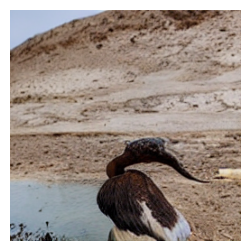

  Time for class #0, Struthio_camelus =  11.4 seconds. Throughput = 12682 images per hour.


Prompt: A photograph of a Somali Ostrich (Struthio molybdophanes): Similar to common ostrich but males have blueish skin on neck and thighs, females are greyish-brown.
  Example synthetic image: 


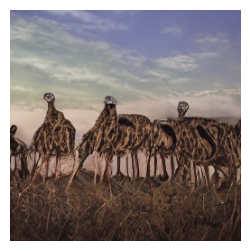

  Time for class #1, Struthio_molybdophanes =  10.7 seconds. Throughput = 13429 images per hour.


Prompt: A photograph of a North African Ostrich (Struthio camelus camelus): Subspecies of common ostrich with pinkish-white neck and legs.
  Example synthetic image: 


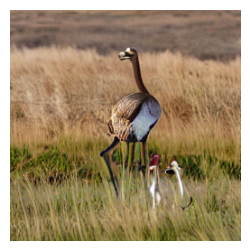

  Time for class #2, Struthio_camelus_camelus =  10.7 seconds. Throughput = 13427 images per hour.


About to make 210800 images for Realm == Food. Will use 34 calls to Stable Diffusion (each making 20 images) for each of 310 classes.

Prompt: A photograph of Bruschetta:  Toasted bread topped with diced tomatoes, basil, and garlic. 
  Example synthetic image: 


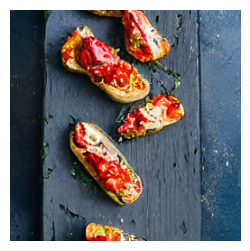

  Time for class #0, Bruschetta =  10.6 seconds. Throughput = 13575 images per hour.


Prompt: A photograph of Deviled Eggs:  Halved boiled eggs filled with creamy, yellow yolk mixture.
  Example synthetic image: 


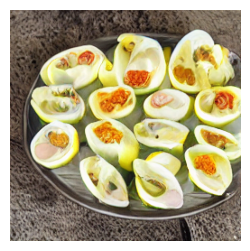

  Time for class #1, Deviled_Eggs =  10.8 seconds. Throughput = 13282 images per hour.


Prompt: A photograph of Shrimp Cocktail:  Chilled, peeled shrimp served around a glass of tangy red cocktail sauce.
  Example synthetic image: 


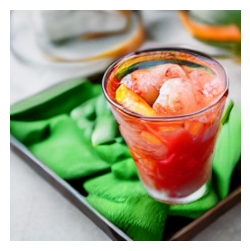

  Time for class #2, Shrimp_Cocktail =  10.8 seconds. Throughput = 13343 images per hour.


About to make 202000 images for Realm == Plants. Will use 10 calls to Stable Diffusion (each making 20 images) for each of 1010 classes.

Prompt: A photograph of a Water Plantain (Alisma plantago-aquatica): Broad, oval leaves with pointed tips, white or pink flowers with three petals.
  Example synthetic image: 


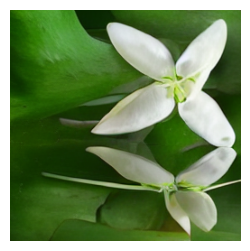

  Time for class #0, Alisma_plantago-aquatica =  10.7 seconds. Throughput = 13456 images per hour.


Prompt: A photograph of a Arrowhead (Sagittaria sagittifolia): Arrow-shaped leaves, white flowers with three petals, grows in water or marsh.
  Example synthetic image: 


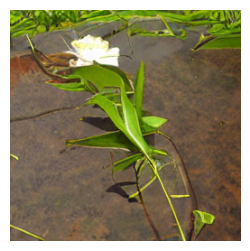

  Time for class #1, Sagittaria_sagittifolia =  10.7 seconds. Throughput = 13419 images per hour.


Prompt: A photograph of a Golden Club (Orontium aquaticum): Oblong leaves, yellow flower spike, grows in water or wet soil.
  Example synthetic image: 


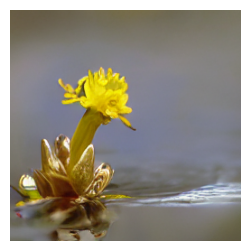

  Time for class #2, Orontium_aquaticum =  10.8 seconds. Throughput = 13273 images per hour.




In [5]:
realms=['Birds','Food','Plants']
num_images_per_prompt_each_realm=[200,680,200]
is_bio=[True,False,True]
for idx,realm in enumerate(realms):
    make_images_for_realm(realm,is_bio[idx],num_images_per_prompt_each_realm[idx],is_demo=True)

## The resulting images are now passed to model pre-training
- the demo in this notebook can be very easily scaled up to full synthetic dataset creation